<a href="https://colab.research.google.com/github/danielmsd1/ML/blob/main/house_prices_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset

In [395]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.python.keras.optimizer_v2.adam import Adam
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Activation,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

In [396]:
df = pd.read_csv("/content/Housing Pricing.csv")
print(df.shape)
df.head(10)

(1460, 77)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939.0,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,0,1,2008,WD,Normal,118000


In [397]:
df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

# Prepare the dataset for training

In [398]:
# Handling the missing data : Replacing the nan values with 0
df.fillna(0)

# Dropping any column with single values
count = df.nunique()
to_del = [i for i,v in enumerate(count) if v == 1]
print(to_del)
df.drop(to_del,axis=1,inplace=True)

[]


Skew value :  1.8828757597682129


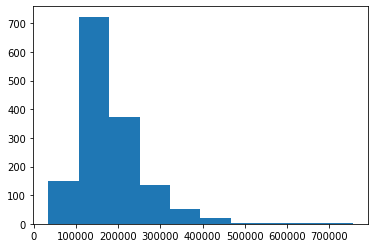

In [399]:
print("Skew value : ",df.SalePrice.skew())
plt.hist(df.SalePrice)
plt.show()

Skew value :  0.12133506220520406


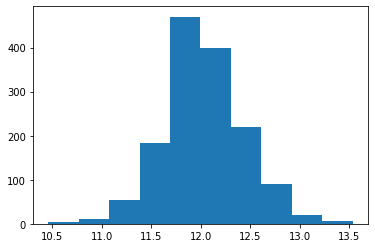

In [400]:
#using nplog to transform the data and improve skew
target = np.log(df.SalePrice)
print("Skew value : ",target.skew())
plt.hist(target)
plt.show()

In [401]:
# We define the array of datatypes (only numerics) to work with
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(df.select_dtypes(include=numerics).columns)
df = df[numerical_vars]
df = df.fillna(0)
df

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,142125


In [402]:
df.values

array([[1.00000e+00, 6.00000e+01, 6.50000e+01, ..., 2.00000e+00,
        2.00800e+03, 2.08500e+05],
       [2.00000e+00, 2.00000e+01, 8.00000e+01, ..., 5.00000e+00,
        2.00700e+03, 1.81500e+05],
       [3.00000e+00, 6.00000e+01, 6.80000e+01, ..., 9.00000e+00,
        2.00800e+03, 2.23500e+05],
       ...,
       [1.45800e+03, 7.00000e+01, 6.60000e+01, ..., 5.00000e+00,
        2.01000e+03, 2.66500e+05],
       [1.45900e+03, 2.00000e+01, 6.80000e+01, ..., 4.00000e+00,
        2.01000e+03, 1.42125e+05],
       [1.46000e+03, 2.00000e+01, 7.50000e+01, ..., 6.00000e+00,
        2.00800e+03, 1.47500e+05]])

In [403]:
#Split the data into dependent (Y) and Independent (X) datasets
X = df.iloc[:,0:37]
Y = df.iloc[:,37]
Y,X

(0       208500
 1       181500
 2       223500
 3       140000
 4       250000
          ...  
 1455    175000
 1456    210000
 1457    266500
 1458    142125
 1459    147500
 Name: SalePrice, Length: 1460, dtype: int64,
         Id  MSSubClass  LotFrontage  LotArea  ...  PoolArea  MiscVal  MoSold  YrSold
 0        1          60         65.0     8450  ...         0        0       2    2008
 1        2          20         80.0     9600  ...         0        0       5    2007
 2        3          60         68.0    11250  ...         0        0       9    2008
 3        4          70         60.0     9550  ...         0        0       2    2006
 4        5          60         84.0    14260  ...         0        0      12    2008
 ...    ...         ...          ...      ...  ...       ...      ...     ...     ...
 1455  1456          60         62.0     7917  ...         0        0       8    2007
 1456  1457          20         85.0    13175  ...         0        0       2    2010
 145

In [404]:
# Scale the dataset into values btn 0 and 1 using MinMaxScaler()
min_max_scaler = MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)
X_train.head(3),X_scale

(        Id  MSSubClass  LotFrontage  LotArea  ...  PoolArea  MiscVal  MoSold  YrSold
 836    837          30         90.0     8100  ...         0        0       6    2007
 1075  1076          70         75.0    13125  ...         0        0       7    2007
 244    245          60          0.0     8880  ...         0        0       5    2010
 
 [3 rows x 37 columns],
 array([[0.00000000e+00, 2.35294118e-01, 2.07667732e-01, ...,
         0.00000000e+00, 9.09090909e-02, 5.00000000e-01],
        [6.85400960e-04, 0.00000000e+00, 2.55591054e-01, ...,
         0.00000000e+00, 3.63636364e-01, 2.50000000e-01],
        [1.37080192e-03, 2.35294118e-01, 2.17252396e-01, ...,
         0.00000000e+00, 7.27272727e-01, 5.00000000e-01],
        ...,
        [9.98629198e-01, 2.94117647e-01, 2.10862620e-01, ...,
         1.61290323e-01, 3.63636364e-01, 1.00000000e+00],
        [9.99314599e-01, 0.00000000e+00, 2.17252396e-01, ...,
         0.00000000e+00, 2.72727273e-01, 1.00000000e+00],
        [1.000000

In [405]:
# Separating the data into training and test sets
X_train, X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3) #X_scale
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((1022, 37), (438, 37), (1022,), (438,))

In [406]:
# # Scaling the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train.head(3)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
140,141,20,70.0,10500,4,5,1971,1971,0.0,432,0,432,864,864,0,0,864,0,0,1,0,3,1,5,1,0.0,0,0,0,0,0,0,0,0,0,4,2010
744,745,120,41.0,5395,8,5,1993,1993,0.0,733,0,604,1337,1337,0,0,1337,1,0,2,0,2,1,5,1,1993.0,2,462,96,0,70,168,0,0,0,10,2008
1020,1021,20,60.0,7024,4,5,2005,2005,0.0,1024,0,108,1132,1132,0,0,1132,1,0,1,1,2,1,5,0,2005.0,2,451,252,64,0,0,0,0,0,6,2008


#Building the model

In [407]:
adam = Adam()

In [408]:
model = Sequential()
model.add(Dense(32,activation='relu',input_dim=37))
model.add(Dense(32,activation='relu'))
model.add(Dense(units=32,activation='relu'))
# model.add(Dense(units=32,activation='relu'))
model.add(Dense(units=1,activation='softmax'))

In [409]:
# Measure how well the model performs and improve it
model.compile(optimizer=adam,
              #optimizer=adam, loss='sparse_categorical_crossentropy',
              loss='binary_crossentropy',
              metrics = ['accuracy'])

#Train the model

In [410]:
hist = model.fit(
    X_train,Y_train,
    batch_size=32,epochs=100,
)

Epoch 1/100
32/32 [==============================] - 1s 2ms/step - loss: -635633927.2727 - accuracy: 0.0000e+00
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: -3424292542.0606 - accuracy: 0.0000e+00
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: -14047480676.8485 - accuracy: 0.0000e+00
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: -47745062539.6364 - accuracy: 0.0000e+00
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: -138670164898.9091 - accuracy: 0.0000e+00
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: -361821603777.9394 - accuracy: 0.0000e+00
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: -795203201210.1818 - accuracy: 0.0000e+00
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: -1577230913908.3635 - accuracy: 0.0000e+00
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: -265153637531

In [411]:
model.evaluate(X_test,Y_test)[1]

14/14 [==============================] - 0s 1ms/step - loss: -43495760871817216.0000 - accuracy: 0.0000e+00


0.0

In [412]:
prediction = model.predict(X_test)
prediction.shape

(438, 1)

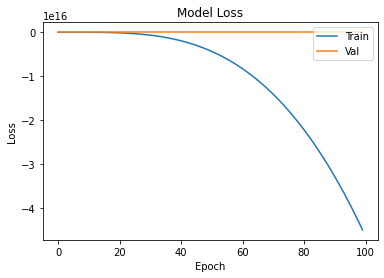

In [416]:
#check whether there is overfitting
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper right')